In [1]:
# @title 🧩 Setup and Core Imports
import os
import sys
import argparse
from pathlib import Path
import pandas as pd
import yaml
import torch
import random
import numpy as np
import copy
import warnings
from collections import defaultdict
import contextlib # For suppressing output
import io # For suppressing output
import gc

# Suppress warnings for a cleaner output
warnings.filterwarnings("ignore") 
warnings.filterwarnings(
    "ignore", 
    message="torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*", 
    category=UserWarning
)
from viewer.view import view

os.chdir('./boltz')
print(os.getcwd())

from model_utils import (
    LigandMPNNWrapper, get_boltz_model, load_canonicals, 
    process_msa, smart_split, clean_memory, 
    save_pdb, chain_to_number, sample_seq, shallow_copy_tensor_dict, 
    binder_binds_contacts, plot_run_metrics, get_cif,
    run_alphafold_step, run_rosetta_step, run_prediction, design_sequence
)
print("✅ Core functionality imported.")

/home/jupyter-yehlin/ProteinHunter/boltz


[20:24:52] Initializing Normalizer


┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2025 [Rosetta PyRosetta4.Release.python310.ubuntu 2025.23+release.e6f643b818cda63c8e00156a266c408faac3c3dd 2025-05-28T17:24:52] retrieved from: http://www.pyrosetta.org
✅ Core functionality imported.


In [ ]:
# @title 🧬 Boltz Configuration Parameters
# --- General Setup ---
gpu_id = 0  # @param {type:"integer"}
grad_enabled = False  # @param {type:"boolean"}
name = "PDL1_two_binder"  # @param {type:"string"}
mode = "binder"  # @param ["unconditional", "binder"]
num_designs = 3  # @param {type:"integer"}
num_cycles = 5  # @param {type:"integer"}
binder_chain = "A"  # @param {type:"string"}
save_dir = f"../results/{name}"
work_dir = os.getcwd() 

# --- Sequence Length ---
min_design_protein_length = 100  # @param {type:"integer"}
max_design_protein_length = 150  # @param {type:"integer"}

# --- Target Protein(s) ---
protein_ids = "B"  # @param {type:"string"}
protein_seqs = 'MAQVQLVETGGGLVQPGGSLRLSCTASGFTFSMHAMTWYRQAPGKQRELVAVITSHGDRANYTDSVRGRFTISRDNTKNMVYLQMNSLKPEDTAVYYCNVPRYDSWGQGTQVTVSSGGLPET'  # @param {type:"string"}
protein_msas = ""  # "" means generate, "empty" is single sequence # @param {type:"string"}
cyclics = ""  # @param {type:"string"}

# --- Non-Protein Components (Ligand/Nucleic Acid) ---
ligand_id = "C" 
ligand_smiles = ""  # @param {type:"string"}
ligand_ccd = "SAM"  # @param {type:"string"}
nucleic_type = "dna"  
nucleic_id = ""
nucleic_seq = ""  # @param {type:"string"}

# --- Templates and Constraints ---
template_path = ""  
template_chain_id = "" 
add_constraints = False  # @param {type:"boolean"}
contact_residues = ""  # e.g., "1,2,5,10" on target chain # @param {type:"string"}
constraint_target_chain = "B" # Target chain for contacts # @param {type:"string"}
contact_cutoff = 10.0  # @param {type:"number"}
max_contact_filter_retries = 6  # @param {type:"integer"}
no_contact_filter = False  # @param {type:"boolean"}

# --- Model & Diffusion Parameters ---
no_potentials = True  # @param {type:"boolean"}
diffuse_steps = 200  # @param {type:"integer"}
recycling_steps = 3  # @param {type:"integer"}
boltz_model_version = "boltz2"  # @param ["boltz1", "boltz2"]
boltz_model_path = os.path.expanduser("~/.boltz/boltz2_conf.ckpt")
ccd_path = Path(os.path.expanduser("~/.boltz/mols"))
logmd = False  # @param {type:"boolean"}

# --- Design & Optimization ---
randomly_kill_helix_feature = False  # @param {type:"boolean"}
negative_helix_constant = 0.2  # @param {type:"number"}
alanine_bias = True  # @param {type:"boolean"}
temperature_start = 0.05  # @param {type:"number"}
temperature_end = 0.001  # @param {type:"number"}
alanine_bias_start = -0.5  # @param {type:"number"}
alanine_bias_end = -0.2  # @param {type:"number"}
omit_AA = "C"  # @param {type:"string"}
all_X = False  # @param {type:"boolean"}
high_iptm_threshold = 0.8  # @param {type:"number"}

# --- Optional: Validation Parameters (External Dependencies) ---
alphafold_dir = os.path.expanduser("~/alphafold3") 
af3_docker_name = "alphafold3_yc"
af3_database_settings = os.path.expanduser("~/alphafold3/alphafold3_data_save")
hmmer_path = os.path.expanduser("~/.conda/envs/alphafold3_venv")
use_msa_for_af3 = False
plot = True # @param {type:"boolean"}
viewer = True # @param {type:"boolean"}

# Re-package parameters into an 'args' object (simple class for dot notation)
class Args:
    def __init__(self, **entries): self.__dict__.update(entries)
args = Args(**locals())

In [9]:
# @title ⚙️ Initialize Models and Prepare Base Data

# --- 1. Model Initialization ---
device = f"cuda:{args.gpu_id}" if torch.cuda.is_available() and args.gpu_id >= 0 else "cpu"
print(f"Using device: {device}")

predict_args = {
    "recycling_steps": args.recycling_steps, "sampling_steps": args.diffuse_steps,
    "diffusion_samples": 1, "write_confidence_summary": True,
    "write_full_pae": False, "write_full_pde": False, "max_parallel_samples": 1,
}

ccd_lib = load_canonicals(os.path.expanduser(str(args.ccd_path)))
boltz_model = get_boltz_model(
    checkpoint=args.boltz_model_path, predict_args=predict_args, device=device, 
    model_version=args.boltz_model_version, no_potentials=args.no_potentials, 
    grad_enabled=args.grad_enabled,
)
designer = LigandMPNNWrapper(os.path.join(args.work_dir, "../LigandMPNN/run.py"))
protein_hunter_save_dir = os.path.join(args.save_dir, "0_protein_hunter_design")
os.makedirs(protein_hunter_save_dir, exist_ok=True)
os.makedirs(args.save_dir, exist_ok=True)

# --- 2. Data Preparation (Condensed from _build_initial_data_dict) ---
sequences = []
# Process multi-chain/MSA inputs
protein_ids_list = smart_split(args.protein_ids)
protein_seqs_list = smart_split(args.protein_seqs)
protein_msas_list = smart_split(args.protein_msas) if args.protein_msas else [""] * len(protein_ids_list)
cyclics_list = smart_split(args.cyclics) if args.cyclics else ["False"] * len(protein_ids_list)

max_len = max(len(protein_ids_list), len(protein_seqs_list), len(protein_msas_list), len(cyclics_list))
for l in [protein_ids_list, protein_seqs_list, protein_msas_list, cyclics_list]:
    while len(l) < max_len: l.append("")

seq_to_indices = defaultdict(list)
for idx, seq in enumerate(protein_seqs_list):
    if seq: seq_to_indices[seq].append(idx)
seq_to_final_msa = {}

# Suppress MSA generation output during this phase
with contextlib.redirect_stdout(io.StringIO()) as f:
    for seq, idx_list in seq_to_indices.items():
        chosen_msa = next((protein_msas_list[i] for i in idx_list if protein_msas_list[i] and protein_msas_list[i] != "empty"), None)
        if chosen_msa is None: chosen_msa = ""
        
        if chosen_msa == "":
            pid = protein_ids_list[idx_list[0]] if protein_ids_list[idx_list[0]] else f"CHAIN_{idx_list[0]}"
            msa_value = process_msa(pid, seq, Path(protein_hunter_save_dir))
            seq_to_final_msa[seq] = str(msa_value)
        elif chosen_msa == "empty":
            seq_to_final_msa[seq] = "empty"
        else:
            seq_to_final_msa[seq] = chosen_msa

# Build sequences list and add X-binder
for pid, seq, cyc in zip(protein_ids_list, protein_seqs_list, cyclics_list):
    if not pid or not seq: continue
    final_msa = seq_to_final_msa.get(seq, "empty")
    cyc_val = cyc.lower() in ["true", "1", "yes"]
    sequences.append({"protein": {"id": [pid], "sequence": seq, "msa": final_msa, "cyclic": cyc_val}})
sequences.append({"protein": {"id": [args.binder_chain], "sequence": "X", "msa": "empty", "cyclic": False}})
if args.ligand_smiles: sequences.append({"ligand": {"id": [args.ligand_id], "smiles": args.ligand_smiles}})
elif args.ligand_ccd: sequences.append({"ligand": {"id": [args.ligand_id], "ccd": args.ligand_ccd}})
if args.nucleic_seq: sequences.append({args.nucleic_type: {"id": [args.nucleic_id], "sequence": args.nucleic_seq}})

# Handle templates and constraints
templates = []
if args.template_path:
    template_path_list = smart_split(args.template_path)
    template_chain_id_list = smart_split(args.template_chain_id) if args.template_chain_id else []
    template_files = [get_cif(tp) for tp in template_path_list]
    for i, template_file in enumerate(template_files):
        t_block = {"cif": template_file} if template_file.endswith(".cif") else {"pdb": template_file}
        if template_chain_id_list and i < len(template_chain_id_list): t_block["chain_id"] = template_chain_id_list[i]
        templates.append(t_block)

data = {"sequences": sequences}
if templates: data["templates"] = templates
pocket_conditioning = args.add_constraints

if args.add_constraints:
    residues = args.contact_residues.split(",")
    contacts = [[args.constraint_target_chain, int(res)] for res in residues if res.strip() != ""]
    constraints = [{"pocket": {"binder": args.binder_chain, "contacts": contacts}}]
    data["constraints"] = constraints

data["sequences"] = sorted(data["sequences"], key=lambda entry: list(entry.values())[0]["id"][0])

any_ligand_or_nucleic = args.ligand_smiles or args.ligand_ccd or args.nucleic_seq
model_type = "ligand_mpnn" if any_ligand_or_nucleic else "soluble_mpnn"

print("✅ Models ready and base data configured.")
print("Mode:", args.mode)
print("Data dictionary (base):\n", data)

Using device: cuda:0


✅ Models ready and base data configured.
Mode: binder
Data dictionary (base):
 {'sequences': [{'protein': {'id': ['A'], 'sequence': 'X', 'msa': 'empty', 'cyclic': False}}, {'protein': {'id': ['B'], 'sequence': 'MAQVQLVETGGGLVQPGGSLRLSCTASGFTFSMHAMTWYRQAPGKQRELVAVITSHGDRANYTDSVRGRFTISRDNTKNMVYLQMNSLKPEDTAVYYCNVPRYDSWGQGTQVTVSSGGLPET', 'msa': '../results/PDL1_two_binder/0_protein_hunter_design/B_env/msa.npz', 'cyclic': False}}, {'ligand': {'id': ['C'], 'ccd': 'SAM'}}], 'constraints': [{'pocket': {'binder': 'A', 'contacts': [['B', 1], ['B', 2], ['B', 5], ['B', 10]]}}]}



=== Starting Design Run 0/2 ===
Binder initial sequence length: 144


❌ Binder does NOT contact required residues after cycle 0. Retrying...
Contacted residue 1 by binder CA
❌ Binder does NOT contact required residues after cycle 0. Retrying...
Contacted residue 10 by binder CA
❌ Binder does NOT contact required residues after cycle 0. Retrying...
Contacted residue 1 by binder CA
Contacted residue 2 by binder CA
Contacted residue 5 by binder CA

--- Run 0, Cycle 1 ---
ipTM: 0.88, pLDDT: 0.62, iPLDDT: 0.45, Ala%: 7.6



--- Run 0, Cycle 2 ---
ipTM: 0.89, pLDDT: 0.71, iPLDDT: 0.55, Ala%: 7.6


<IPython.core.display.Javascript object>


--- Run 0, Cycle 3 ---
ipTM: 0.86, pLDDT: 0.84, iPLDDT: 0.63, Ala%: 3.5


<IPython.core.display.Javascript object>


--- Run 0, Cycle 4 ---
ipTM: 0.92, pLDDT: 0.90, iPLDDT: 0.83, Ala%: 3.5


<IPython.core.display.Javascript object>


--- Run 0, Cycle 5 ---
ipTM: 0.93, pLDDT: 0.91, iPLDDT: 0.84, Ala%: 4.9


<IPython.core.display.Javascript object>

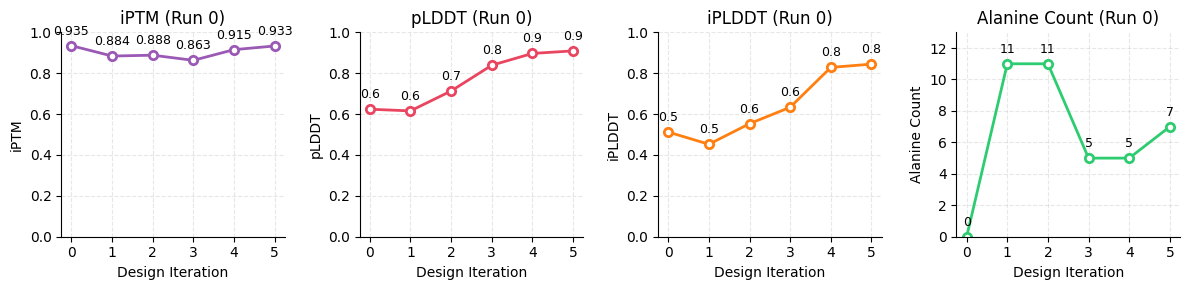


=== Starting Design Run 1/2 ===
Binder initial sequence length: 125
Contacted residue 1 by binder CA
❌ Binder does NOT contact required residues after cycle 0. Retrying...
❌ Binder does NOT contact required residues after cycle 0. Retrying...
Contacted residue 1 by binder CA
Contacted residue 2 by binder CA
Contacted residue 10 by binder CA

--- Run 1, Cycle 1 ---
ipTM: 0.86, pLDDT: 0.58, iPLDDT: 0.44, Ala%: 21.6



--- Run 1, Cycle 2 ---
ipTM: 0.80, pLDDT: 0.65, iPLDDT: 0.51, Ala%: 12.8


<IPython.core.display.Javascript object>


--- Run 1, Cycle 3 ---
ipTM: 0.93, pLDDT: 0.68, iPLDDT: 0.46, Ala%: 15.2


<IPython.core.display.Javascript object>


--- Run 1, Cycle 4 ---
ipTM: 0.93, pLDDT: 0.69, iPLDDT: 0.54, Ala%: 15.2


<IPython.core.display.Javascript object>


--- Run 1, Cycle 5 ---
ipTM: 0.91, pLDDT: 0.85, iPLDDT: 0.64, Ala%: 9.6


<IPython.core.display.Javascript object>

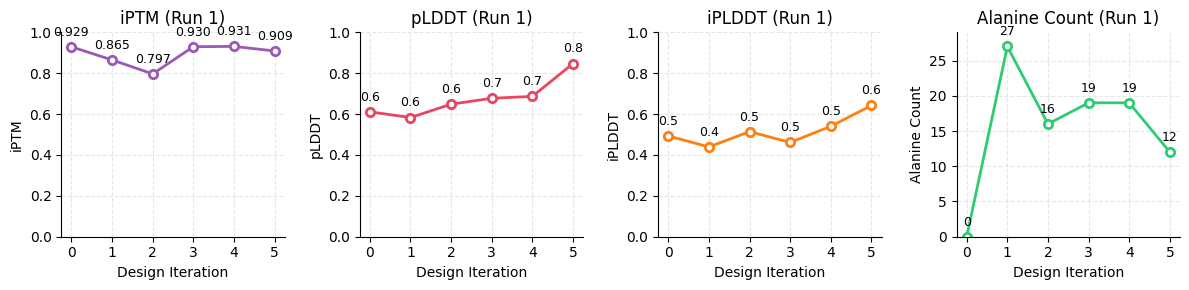


=== Starting Design Run 2/2 ===
Binder initial sequence length: 145
Contacted residue 1 by binder CA
Contacted residue 2 by binder CA

--- Run 2, Cycle 1 ---
ipTM: 0.92, pLDDT: 0.71, iPLDDT: 0.50, Ala%: 12.4



--- Run 2, Cycle 2 ---
ipTM: 0.93, pLDDT: 0.84, iPLDDT: 0.77, Ala%: 14.5


<IPython.core.display.Javascript object>


--- Run 2, Cycle 3 ---
ipTM: 0.93, pLDDT: 0.85, iPLDDT: 0.67, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 2, Cycle 4 ---
ipTM: 0.93, pLDDT: 0.90, iPLDDT: 0.74, Ala%: 9.0


<IPython.core.display.Javascript object>


--- Run 2, Cycle 5 ---
ipTM: 0.77, pLDDT: 0.84, iPLDDT: 0.53, Ala%: 9.7


<IPython.core.display.Javascript object>

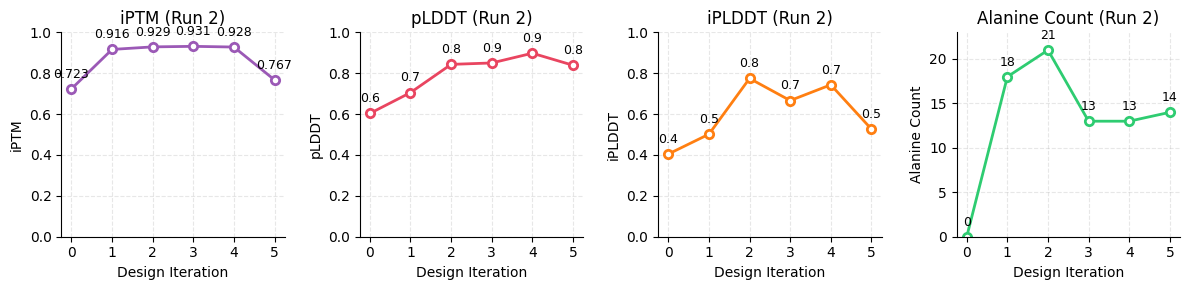


✅ All run/cycle metrics saved to ../results/PDL1_two_binder/summary_all_runs.csv


In [ ]:
# @title 🚀 Execute Design and Optimization Loop
# Replicate the core logic from _run_design_cycle and run_pipeline's execution part
import contextlib
import io

# NOTE: Using viewer object from global scope for incremental updates



all_run_metrics = []

for design_id in range(args.num_designs):
    if viewer:
        viewer = view()
        viewer.clear() 
        
    run_id = str(design_id)
    run_save_dir = os.path.join(args.save_dir, f"run_{run_id}")
    os.makedirs(run_save_dir, exist_ok=True)

    data_cp = copy.deepcopy(data)
    
    print(f"\n=======================================================")
    print(f"=== Starting Design Run {run_id}/{args.num_designs - 1} ===")
    print(f"=======================================================")

    best_iptm = float("-inf")
    best_seq = None
    best_structure = None
    best_output = None
    best_pdb_filename = None
    best_cycle_idx = -1
    best_alanine_percentage = None
    run_metrics = {"run_id": run_id}
    
    # --- Initial Sequence Assignment ---
    binder_length = random.randint(args.min_design_protein_length, args.max_design_protein_length)
    new_seq = sample_seq(binder_length, all_X=args.all_X)
    
    # Update binder sequence in the data dictionary copy
    for seq_entry in data_cp["sequences"]:
        if "protein" in seq_entry and args.binder_chain in seq_entry["protein"]["id"]:
            seq_entry["protein"]["sequence"] = new_seq
            break
    print(f"Binder initial sequence length: {binder_length}")

    # ========== Cycle 0 structure prediction (with contact filtering) ==========
    contact_filter_attempt = 0
    pdb_filename = ""
    structure = None
    output = None

    while True:
        # SUPPRESS UNWANTED MSA MESSAGES during prediction
        with contextlib.redirect_stdout(io.StringIO()) as f:
            output, structure = run_prediction(
                data_cp, args.binder_chain,
                randomly_kill_helix_feature=args.randomly_kill_helix_feature,
                negative_helix_constant=args.negative_helix_constant,
                boltz_model=boltz_model, ccd_lib=ccd_lib, ccd_path=args.ccd_path,
                logmd=args.logmd, device=device, boltz_model_version=args.boltz_model_version,
                pocket_conditioning=pocket_conditioning,
            )

        # Save Cycle 0 PDB
        pdb_filename = f"{run_save_dir}/{args.name}_run_{run_id}_predicted_cycle_0.pdb"
        plddts = output["plddt"].detach().cpu().numpy()[0]
        save_pdb(structure, output["coords"], plddts, pdb_filename)
        
        # Contact filtering (only if configured)
        contact_check_okay = True
        if args.contact_residues.strip() and not args.no_contact_filter:
            try:
                binds = binder_binds_contacts(
                    pdb_filename, args.binder_chain, args.constraint_target_chain, args.contact_residues, cutoff=args.contact_cutoff
                )
                if not binds:
                    print(f"❌ Binder does NOT contact required residues after cycle 0. Retrying...")
                    contact_check_okay = False
            except Exception as e:
                print(f"WARNING: Could not perform binder-contact check: {e}")
                contact_check_okay = True
        
        if contact_check_okay:
            break
        else:
            contact_filter_attempt += 1
            if contact_filter_attempt >= args.max_contact_filter_retries:
                print("⚠️ Maximum contact filter retries reached. Proceeding anyway.")
                break
            
            # Resample initial sequence
            new_seq = sample_seq(binder_length, all_X=args.all_X)
            for seq_entry in data_cp["sequences"]:
                if "protein" in seq_entry and args.binder_chain in seq_entry["protein"]["id"]:
                    seq_entry["protein"]["sequence"] = new_seq
                    break
            clean_memory()

    # --- Capture Cycle 0 metrics (same logic as before) ---
    binder_chain_idx = chain_to_number[args.binder_chain]
    pair_chains = output['pair_chains_iptm']
    if len(pair_chains) > 1:
        values = [(pair_chains[binder_chain_idx][i].detach().cpu().numpy() + pair_chains[i][binder_chain_idx].detach().cpu().numpy()) / 2.0
            for i in range(len(pair_chains)) if i != binder_chain_idx
        ]
        cycle_0_iptm = float(np.mean(values) if values else 0.0)
    else:
        cycle_0_iptm = 0.0
    run_metrics["cycle_0_iptm"] = cycle_0_iptm
    run_metrics["cycle_0_plddt"] = float(output.get("complex_plddt", torch.tensor([0.0])).detach().cpu().numpy()[0])
    run_metrics["cycle_0_iplddt"] = float(output.get("complex_iplddt", torch.tensor([0.0])).detach().cpu().numpy()[0])
    run_metrics["cycle_0_alanine"] = 0
    run_metrics["cycle_0_seq"] = new_seq

    # ===== Optimization Cycles (Cycle 1 to num_cycles) =====
    for cycle in range(args.num_cycles):
        print(f"\n--- Run {run_id}, Cycle {cycle + 1} ---")
        
        # Calculate temperature and bias
        cycle_norm = (cycle / (args.num_cycles - 1)) if args.num_cycles > 1 else 0.0
        alpha = args.alanine_bias_start - cycle_norm * (args.alanine_bias_start - args.alanine_bias_end)
        temperature = args.temperature_start - cycle_norm * (args.temperature_start - args.temperature_end)
        
        design_kwargs = {
            "pdb_file": pdb_filename, "temperature": temperature, "chains_to_design": args.binder_chain,
            "omit_AA": f"{args.omit_AA},P" if cycle == 0 else args.omit_AA
        }
        if args.alanine_bias: design_kwargs["bias_AA"] = f"A:{alpha}"

        seq_str, logits = design_sequence(designer, model_type, **design_kwargs)
        seq = seq_str.split(":")[chain_to_number[args.binder_chain]]
        
        alanine_count = seq.count("A")
        alanine_percentage = alanine_count / binder_length if binder_length else 0.0
        for seq_entry in data_cp["sequences"]:
            if "protein" in seq_entry and args.binder_chain in seq_entry["protein"]["id"]:
                seq_entry["protein"]["sequence"] = seq
                break

        # SUPPRESS UNWANTED MSA MESSAGES during prediction
        with contextlib.redirect_stdout(io.StringIO()) as f:
            output, structure = run_prediction(
                data_cp, args.binder_chain, seq=seq,
                randomly_kill_helix_feature=False, negative_helix_constant=0.0, 
                boltz_model=boltz_model, ccd_lib=ccd_lib, ccd_path=args.ccd_path, 
                logmd=False, device=device
            )
        
        # Compute ipTM
        current_chain_idx = chain_to_number[args.binder_chain]
        pair_chains = output['pair_chains_iptm']
        if len(pair_chains) > 1:
            values = [(pair_chains[current_chain_idx][i].detach().cpu().numpy() + pair_chains[i][current_chain_idx].detach().cpu().numpy()) / 2.0
                for i in range(len(pair_chains)) if i != current_chain_idx
            ]
            current_iptm = float(np.mean(values) if values else 0.0)
        else:
            current_iptm = 0.0
        
        # Update best structure
        if alanine_percentage <= 0.20 and current_iptm > best_iptm:
            best_iptm = current_iptm
            best_structure = copy.deepcopy(structure)
            best_output = shallow_copy_tensor_dict(output)
            best_pdb_filename = f"{run_save_dir}/{args.name}_run_{run_id}_best_structure.pdb"
            best_plddts = best_output["plddt"].detach().cpu().numpy()[0]
            save_pdb(best_structure, best_output["coords"], best_plddts, best_pdb_filename)
            best_cycle_idx = cycle + 1
            best_seq = seq
            best_alanine_percentage = alanine_percentage

        # Record metrics
        curr_plddt = float(output.get("complex_plddt", torch.tensor([0.0])).detach().cpu().numpy()[0])
        curr_iplddt = float(output.get("complex_iplddt", torch.tensor([0.0])).detach().cpu().numpy()[0])
        run_metrics[f"cycle_{cycle + 1}_iptm"] = current_iptm
        run_metrics[f"cycle_{cycle + 1}_plddt"] = curr_plddt
        run_metrics[f"cycle_{cycle + 1}_iplddt"] = curr_iplddt
        run_metrics[f"cycle_{cycle + 1}_alanine"] = alanine_count
        run_metrics[f"cycle_{cycle + 1}_seq"] = seq
        
        print(f"ipTM: {current_iptm:.2f}, pLDDT: {curr_plddt:.2f}, iPLDDT: {curr_iplddt:.2f}, Ala%: {alanine_percentage*100:.1f}")

        pdb_filename = f"{run_save_dir}/{args.name}_run_{run_id}_predicted_cycle_{cycle + 1}.pdb"
        plddts = output["plddt"].detach().cpu().numpy()[0]
        save_pdb(structure, output["coords"], plddts, pdb_filename)
        
        if viewer:
            viewer.from_pdb(pdb_filename)
        
        clean_memory()
        
    # --- Finalize and Plot Metrics ---
    run_metrics["best_iptm"] = float(best_iptm if best_iptm != float("-inf") else np.nan)
    run_metrics["best_cycle"] = best_cycle_idx
    run_metrics["best_seq"] = best_seq
    if best_output:
        run_metrics["best_plddt"] = float(best_output.get("complex_plddt", torch.tensor([np.nan])).detach().cpu().numpy()[0])
    else:
        run_metrics["best_plddt"] = np.nan
    all_run_metrics.append(run_metrics)
    
    if args.plot:
        plot_run_metrics(run_save_dir, args.name, run_id, args.num_cycles, run_metrics)


# ===== Save All Run Metrics to CSV =====
summary_csv = os.path.join(args.save_dir, "summary_all_runs.csv")
df = pd.DataFrame(all_run_metrics)
columns = ["run_id"]
for i in range(args.num_cycles + 1):
    columns.extend([f"cycle_{i}_iptm", f"cycle_{i}_plddt", f"cycle_{i}_iplddt", f"cycle_{i}_alanine", f"cycle_{i}_seq"])
columns.extend(["best_iptm", "best_cycle", "best_plddt", "best_seq"])

for col in columns:
    if col not in df.columns:
        df[col] = np.nan
df = df[[c for c in columns if c in df.columns]]
df.to_csv(summary_csv, index=False)
print(f"\n✅ All run/cycle metrics saved to {summary_csv}")

In [5]:
# @title ⚙️ Optional: Downstream Validation (Requires External Setup)
# Determine target type
target_type = "protein"
if args.nucleic_seq: target_type = "nucleic"
elif args.ligand_smiles or args.ligand_ccd: target_type = "small_molecule"

success_dir = os.path.join(args.save_dir, "1_af3_rosetta_validation")
high_iptm_yaml_dir = os.path.join(args.save_dir, "high_iptm_yaml")

# AlphaFold step 
af_output_dir, af_output_apo_dir, af_pdb_dir, af_pdb_dir_apo = run_alphafold_step(
    high_iptm_yaml_dir, args.alphafold_dir, args.af3_docker_name, args.af3_database_settings, args.hmmer_path, 
    success_dir, args.work_dir, binder_id=args.binder_chain, gpu_id=args.gpu_id, high_iptm=True, use_msa_for_af3=args.use_msa_for_af3
)

# Rosetta step 
run_rosetta_step(
    success_dir, af_pdb_dir, af_pdb_dir_apo, binder_id=args.binder_chain, target_type=target_type
)

print("✅ Pipeline execution complete. Check results in the output directory.")

Starting AlphaFold validation step...
alphafold_dir /home/jupyter-yehlin/alphafold3
afdb_dir /home/jupyter-yehlin/alphafold3/alphafold3_data_save
hmmer_path /home/jupyter-yehlin/.conda/envs/alphafold3_venv


FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-yehlin/ProteinHunter/boltz/boltz/utils/alphafold.sh'